<a href="https://colab.research.google.com/github/Frodo-Swaggins/COMP702PROJECT/blob/main/comp702project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

START OF PREPROCESSING

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#imports and creating the path to the images
import os
import cv2
cv2.__version__
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
from scipy.stats import skew
from scipy.stats import entropy as en
from skimage.morphology import disk

mypath = '/content/drive/MyDrive/RandNotes'

onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [ ]:
#Opening the images and loading them as image objects into an array using open cv
images = []
count = 0

for fil in onlyfiles:
  imagepath = '/content/drive/MyDrive/RandNotes/' + fil
  image = cv2.imread(imagepath)
  images.append(image)

plt.imshow(images[0])
labels = []
for name in onlyfiles:
  if '100' in name:
    labels.append('R100')
  elif '200' in name:
    labels.append('R200')
  elif '50' in name:
    labels.append('R50')
  elif '10' in name:
    labels.append('R10')
  elif '20' in name:
    labels.append('R20')
print(len(labels))
print(labels)
print(onlyfiles)


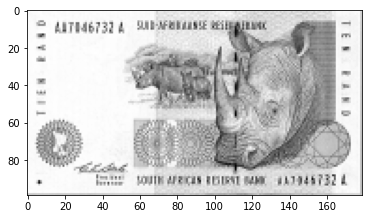

In [4]:
#grayscale conversion on the array of images
grays = []
for image in images:
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  grays.append(gray)
plt.imshow(grays[0], cmap = 'gray')

In [ ]:
#Thresholding of the array of images
binary = []
for gray in grays:
  blurred = cv2.GaussianBlur(gray, (7, 7), 0)
  ret, thresh1 = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY)
  ret, thresh2 = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV)
  ret, thresh3 = cv2.threshold(gray, 120, 255, cv2.THRESH_TRUNC)
  ret, thresh4 = cv2.threshold(gray, 120, 255, cv2.THRESH_TOZERO)
  ret, thresh5 = cv2.threshold(gray, 120, 255, cv2.THRESH_TOZERO_INV)
  ret, thresh6 = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  adaptiveThresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 10)
 
  binary.append(thresh4)
plt.imshow(binary[0], cmap = 'gray')

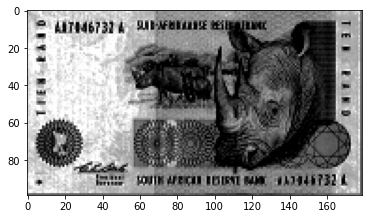

In [6]:
#Histogram normalisation of the therholded array of images
equ = []

for bin in binary:
  equalised = cv2.equalizeHist(bin)
  equ.append(equalised)

plt.imshow(equ[0], cmap = 'gray')

In [ ]:
#Data augmentation is performed on the equalised images
#We take the first half (0-25) of the images and rotate them 90 degrees clockwise
#We take the second half (26-49) of the images and rotate them 90 degrees counterclockwise
#We do this to increase the size of our dataset
labels_extended = []
preprocessed = []
for i in range (len(equ)):
  if(i<=25):
    preprocessed.append(equ[i])
    labels_extended.append(labels[i])
    preprocessed.append(cv2.rotate(equ[i],cv2.cv2.ROTATE_90_CLOCKWISE))
    labels_extended.append(labels[i])
  if(i<=49 and i>25):
    preprocessed.append(equ[i])
    labels_extended.append(labels[i])
    preprocessed.append(cv2.rotate(equ[i],cv2.cv2.ROTATE_90_COUNTERCLOCKWISE))
    labels_extended.append(labels[i])
plt.imshow(preprocessed[21], cmap = 'gray')
print(labels_extended[21])

END OF PREPROCESSING

ENHANCEMENT

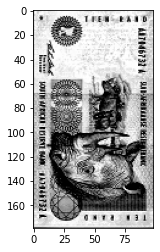

In [8]:
#Enhancement code
hist=[]
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
for pp in preprocessed:
  hist.append(clahe.apply(pp))

plt.imshow(hist[1], cmap = 'gray')

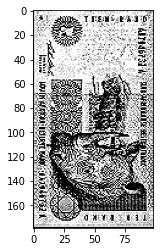

In [11]:
#Sharpening
sharp=[]
for h in hist:
  sharp.append(cv2.filter2D(src=h,ddepth=0,kernel=np.array([[0, -1, 0],[-1, 5,-1],[0, -1, 0]])))

plt.imshow(sharp[1],cmap='gray')

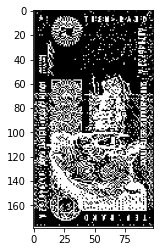

In [12]:
#Segmentation
from scipy import optimize,signal

def th_global(img):
    t = img.mean() #Image's mean intensity
    t_new = 1
    flag = 1
    while np.abs(t-t_new) >0.5:
            if flag ==0: # skip the first iteration
                t = t_new
            g1 = img[img>t]
            g2 = img[img <= t]
            m1 = g1.mean()
            m2 = g2.mean()
            t_new = (m1+m2)*0.5
            flag = 0
    return t_new

def adaptive(img , kernel_size, method = "bin_inv"):
    I = img.copy()
    if (kernel_size % 2) == 0:  # check if the size is even
        kernel_size += 1  # if it does -> make odd. by +1 we more % of the signal
    kernel = np.ones((kernel_size, kernel_size)) / (kernel_size**2)
    t = signal.convolve2d(I,kernel, mode='same')
    if method == "bin":
        I[I <= t] = 0
    if method =="bin_inv":
        I[I > t] = 0
    I[I > 0] = 255
    return I

def kernel_Gauss(kernel_size,sigma): #creates gaussian kernel with given size, and std (sigma)
    ax = np.linspace(- (kernel_size-1) / 2,  (kernel_size-1) / 2,  kernel_size)
    x, y = np.meshgrid(ax,ax)
    kernel = (1 / (2 * np.pi * sigma ** 2)) * np.exp(-(np.square(x) + np.square(y)) / (2 * (sigma ** 2)))
    return kernel / kernel.sum()

def adaptiveGauss(img , kernel_size, method = "bin"):
    I = img.copy()
    sigma = 0.3*((kernel_size-1)*0.5 - 1) + 0.8
    if (kernel_size % 2) == 0:  # check if the size is even
        kernel_size += 1  # if it does -> make odd. by +1 we more % of the signal
    kernel = kernel_Gauss(kernel_size,sigma)
    t = signal.convolve2d(I,kernel, mode='same')
    if method == "bin":
        I[I <= t] = 0
    if method =="bin_inv":
        I[I > t] = 0
    I[I > 0] = 255
    return I

segmented = []

for num_of_im in range(len(sharp)):
    img_samp = sharp[num_of_im]
    img_samp = cv2.GaussianBlur(img_samp ,(3,3),cv2.BORDER_DEFAULT) #apply some smoothing
    ret,thresh1 = cv2.threshold(sharp[num_of_im],th_global(sharp[num_of_im]),255,cv2.THRESH_BINARY_INV)
    #thh_inv = adaptive(img_samp , 109)
    #thh_inv_g = adaptiveGauss(img_samp,109)
    segmented.append(thresh1)
    #plt.imshow(thh_inv_g,cmap='gray')

plt.imshow(segmented[1],cmap='gray')

https://developpaper.com/simple-implementation-of-region-growing-in-python/ - Source used for segmentation code

In [ ]:
# # importing required libraries
# #!pip install mahotas
# import mahotas
# import numpy as np
# from pylab import imshow, show
# import os
 
# # haar transform 
# h = mahotas.haar(sharp[1])
# # showing image
# print("Image with haar transform")
# imshow(h)
# show()



FEATURE EXTRACTION

In [13]:

from scipy.stats.stats import kurtosis
from scipy.ndimage.measurements import variance
import math
from scipy import ndimage
# Hu moment features extracted from segmented images
Hu_moment_features = []
for i in segmented:
  im = i
  # Calculate Moments
  moments = cv2.moments(im)
  # Calculate Hu Moments
  huMoments = cv2.HuMoments(moments)
  # Log scale hu moments
  for i in range(0,7):
    huMoments[i] = -1* math.copysign(1.0, huMoments[i]) * math.log10(abs(huMoments[i]))
  # Append features vector to array of feature vectors
  Hu_moment_features.append(huMoments)

#print((Hu_moment_features[0]))
#print(ndimage.variance(sharp[0]))

# variance_array = []
# for i in sharp:
#   variance_array.append(np.var(i))
# print('variance ',variance_array[0])

# skewness_array = []
# for i in sharp:
#   skewness_array.append(skew(np.array(i).flatten()))
# print('skewness ',skewness_array[0])

# kurtosis_array = []
# for i in sharp:
#   kurtosis_array.append(kurtosis(np.array(i).flatten()))
# print('kurtosis ',kurtosis_array[0])

# entropy_array = []
# for i in sharp:
#   pd_series = pd.Series(np.array(i).flatten())
#   counts = pd_series.value_counts()
#   #entropy_array.append(e(counts))
# #print(entropy_array[0])

# a = [1,2,2,3,3,3]

# pd_series = pd.Series(a)
# a = pd.Series(a)
# print(en(a.value_counts()))
# a = np.array(a)
# data = np.unique(a,return_counts=True)
# print(en(a))
# normalized_dependency_matrix = []
# normalized_dependency_matrices = []
# for i in sharp:
#   R = i.sum()
#   for j in range(len(i)):
#     for k in range(len(i[j])):
#         normalized_dependency_matrix.append((i[j][k])/R)
#   normalized_dependency_matrices.append(normalized_dependency_matrix)
#   normalized_dependency_matrix = []

# Haralick feature extraction
haralick_features = []
!pip install mahotas
import mahotas as mt
for i in segmented:
  texture = mt.features.haralick(i)
  ht_mean = texture.mean(axis=0)
  haralick_features.append(ht_mean)

haralick_features[0]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.7 MB 7.2 MB/s 


array([ 3.09731795e-01,  2.19908029e+04,  2.75077161e-01,  1.51675039e+04,
        6.61815230e-01,  1.89009344e+02,  3.86792126e+04,  1.50969701e+00,
        1.84788698e+00,  2.14290366e-03,  9.22875281e-01, -5.71777351e-02,
        3.20382499e-01])

Training

In [ ]:
# We have two types of features vectors to work with
import numpy as np
import pandas as pd
#Hu
arr1 = np.array(Hu_moment_features)
x,y,z = arr1.shape
arr1 = arr1.reshape(x,y)
print(arr1[0])
banknotes = pd.DataFrame(arr1, columns = ['14','15','16','17','18','19','20'])
print(banknotes.head())
#banknotes['Class'] = labels_extended
banknotes.head()
#Haralick
arr2 = np.array(haralick_features)
x,y = arr2.shape
arr2 = arr2.reshape(x,y)
banknotes2 = pd.DataFrame(arr2, columns = ['1','2','3','4','5','6','7','8','9','10','11','12','13'])
#banknotes2 = banknotes2.append(banknotes)
banknotes2 = pd.concat([banknotes2, banknotes], axis="columns")
banknotes2=banknotes2.div(banknotes2.sum(axis=1), axis=0)
banknotes2['Class'] = labels_extended

banknotes2.head()

In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

resizedFeatures = []

features = banknotes2.iloc[:,:-1]
for feature in features:
  resizedFeatures = scaler.fit_transform(banknotes2.iloc[:,:-1].values)

resizeFeatures = pd.DataFrame(resizedFeatures, columns = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'])

In [23]:
from sklearn.model_selection import train_test_split

#x= banknotes2.iloc[:,:-1].values
x = resizedFeatures
y= banknotes2.iloc[:,-1].values

banknotes2.head()
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)
#print(x)
#print(y)

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=5,weights='distance',algorithm = 'kd_tree',metric = 'euclidean')
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
acc = classifier.score(X_test, y_test)
print("[INFO] accuracy: {:.2f}%".format(acc * 100))


from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Preliminary model score:
0.9


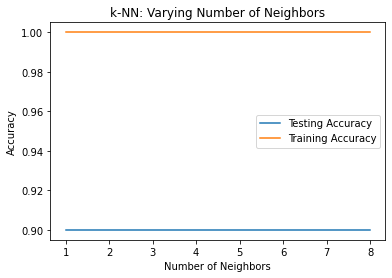

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split  

print("Preliminary model score:")
print(classifier.score(X_test,y_test))

no_neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(no_neighbors))
test_accuracy = np.empty(len(no_neighbors))

for i, k in enumerate(no_neighbors):
    # We instantiate the classifier
    knn = KNeighborsClassifier(n_neighbors=k,weights='distance',algorithm = 'kd_tree',metric = 'euclidean')
    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    
    # Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    # Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Visualization of k values vs accuracy

plt.title('k-NN: Varying Number of Neighbors')
plt.plot(no_neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(no_neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


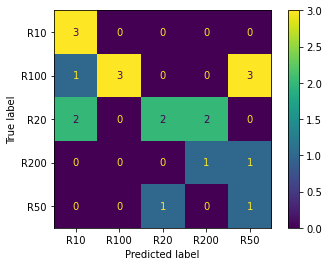

[[3 0 0 0 0]
 [0 7 0 0 0]
 [2 0 4 0 0]
 [0 0 0 2 0]
 [0 0 0 0 2]]


In [27]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

clf = SVC(random_state=0)
clf.fit(X_train, y_train)

plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

print(confusion_matrix(y_test,y_pred))

Minimum error:- 0.1 at K = 0


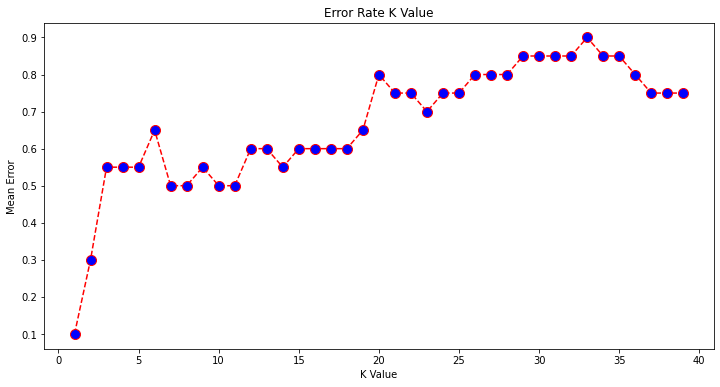

In [28]:
#since k=5 only gave us a 40% accuracy, we calculate the error rate of the values to see which k value gives us the lowest error and will provide the highest accuracy
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')
print("Minimum error:-",min(error),"at K =",error.index(min(error)))

In [34]:
#SVM
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred,average="weighted"))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred,average="weighted"))

Accuracy: 0.75
Precision: 0.8699999999999999
Recall: 0.75
